# 04 - AgglomerativeClustering

* [Hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering)
* [sklearn.cluster.AgglomerativeClustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)
* [Example: Agglomerative clustering with and without structure](http://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_clustering.html)

In [15]:
import nltk
import pandas as pd
import numpy as np
import pickle
import pymongo
import seaborn as sns
import string
import re
import time

## NLP
from nltk.corpus import treebank, stopwords
from nltk import bigrams, trigrams
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.neighbors import kneighbors_graph

## Database
from pymongo import MongoClient

## Visualization
import matplotlib.pyplot as plt

%matplotlib inline

In [16]:
def pickleme(temp, filename):
    
    with open(filename + '.pkl', 'w') as picklefile:
        pickle.dump(temp, picklefile)
    
    return

In [17]:
def getpickle(filename):

    try:
        with open(filename + '.pkl', 'rb') as picklefile:
            return pickle.load(picklefile)
    except:
        return 'There was an error trying to read this file.  Please check the filename or path.'

In [4]:
def tokenizenstem(temp, stem = True, nouns = False):
    
    global stopwords
    
    temptokens = []
    
    if nouns:
        blob = TextBlob(temp)
        tokens = blob.noun_phrases
    else:
        tokens = nltk.word_tokenize(temp)
    
    ##  Creates instance of WordNetLemmatizer
    wnl = WordNetLemmatizer()
    
    for word in tokens:
        if word.lower() not in stopwords and word not in string.punctuation and len(word) > 2 and re.search('[a-zA-Z]', word):
            if stem:
                temptokens.append(wnl.lemmatize(word.lower()))
            else:
                temptokens.append(word.lower())
    
    return temptokens

In [5]:
def getstopwords():

    STOP_WORDS = list(getpickle('stopwords'))
    stopwords = getpickle('resumestopwords')
    
    stopwords = [item for sublist in [list(STOP_WORDS) + stopwords] for item in sublist]
    
    return stopwords

In [6]:
def addtostoplist(tempword):
    
    stopwords = getpickle('resumestopwords')
    
    stopwords.append(tempword)
    
    stopwords = list(set(stopwords))
    
    pickleme(stopwords, 'resumestopwords')
    
    print tempword + ' added to State of the Union stop word list.'
    
    return

In [7]:
stopwords = getstopwords()
colors = getpickle('tableaucolors')

### Start-up mongoDB and load resume database

In [8]:
! brew services start mongodb

Service `mongodb` already started, use `brew services restart mongodb` to restart.


In [9]:
# ! brew services stop mongodb

In [10]:
## Initialize MongoDB for use
client = MongoClient()
db = client['resume_db']
resumes = db.resume_collection

In [11]:
print "Count of number of documents:", resumes.count()
print "Keys in one example document:", resumes.find_one().keys()
# resumes.find_one() # Uncomment this line to see what a full document looks like.

Count of number of documents: 73
Keys in one example document: [u'_id', u'Id', u'Resume']


In [12]:
corpus = []
tokens = []

for resume in resumes.find({}, {'Resume' : 1, "_id": 0}):
    corpus.append(resume['Resume'])
    tokens.append(tokenizenstem(resume['Resume'], stem = True, nouns = False))

print len(corpus), len(tokens)

73 73


### AgglomerativeClustering

In [13]:
ngrams = 3
mxdf = 0.45
mindf = 0.05

vect = CountVectorizer(input = 'content', encoding = 'utf-8', decode_error = 'strict', 
                       strip_accents = None, lowercase=True, preprocessor = None, 
                       tokenizer = tokenizenstem, stop_words = stopwords,
                       token_pattern='(?u)\b\w\w+\b', ngram_range = (1, ngrams), 
                       analyzer = 'word', max_df = mxdf, min_df = mindf, max_features = None,
                       vocabulary = None, binary = False) 

x = vect.fit_transform(corpus)

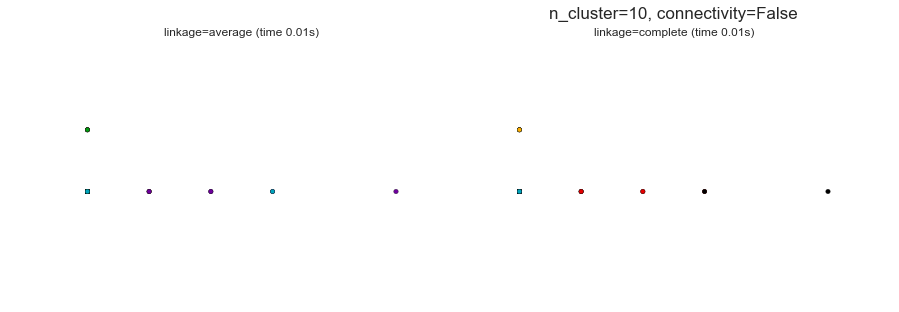

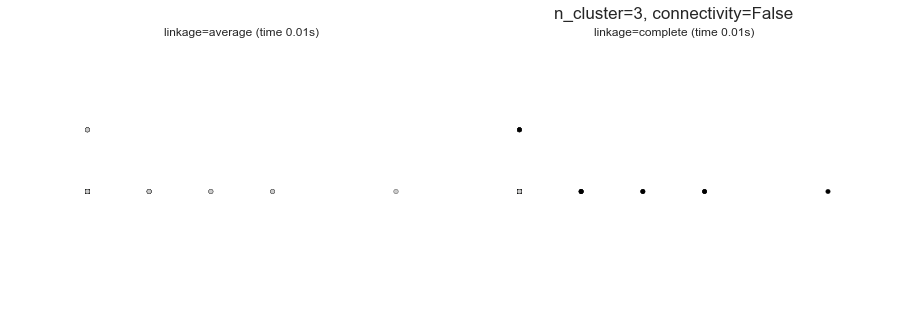

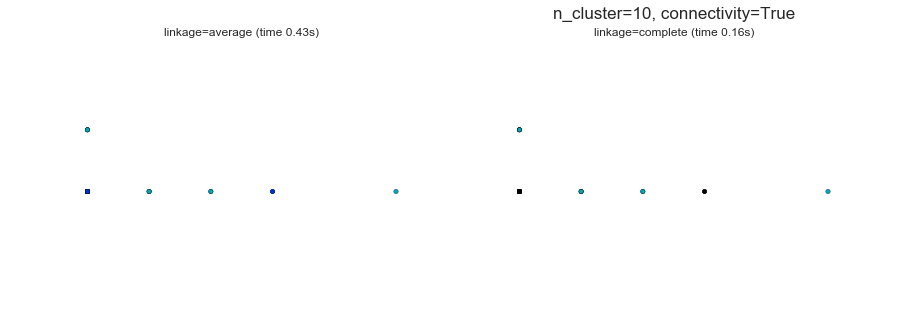

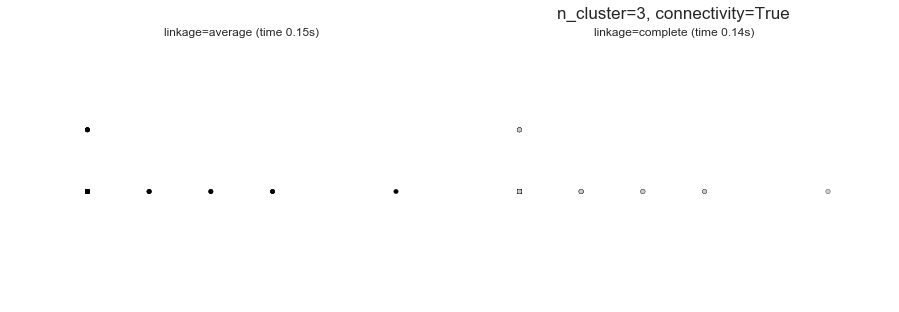

In [22]:
X = x.toarray()
knn = 10

knn_graph = kneighbors_graph(X, knn, include_self=False)

for connectivity in (None, knn_graph):
    for n_clusters in (knn, 3):
        plt.figure(figsize=(18, 4))
        
        for index, linkage in enumerate(('average', 'complete')):

            plt.subplot(1, 3, index + 1)
            model = AgglomerativeClustering(linkage = linkage,
                                            affinity = 'cosine',
                                            connectivity = connectivity,
                                            n_clusters = n_clusters)
            t0 = time.time()
            model.fit(X)
            elapsed_time = time.time() - t0
            
            plt.scatter(X[:, 0], X[:, 1], c=model.labels_, cmap=plt.cm.spectral)
            plt.title('linkage=%s (time %.2fs)' % (linkage, elapsed_time),
                      fontdict=dict(verticalalignment='top'))
            
            plt.axis('equal')
            plt.axis('off')

            plt.subplots_adjust(bottom=0, top=.89, wspace=0, left=0, right=1)
            plt.suptitle('n_cluster=%i, connectivity=%r' %
                         (n_clusters, connectivity is not None), size=17)


plt.show()

As the plots illustrate, the resume corpus is not large enough to make an effective determination of the clustering activity.